In [1]:
import numpy as np
import pandas as pd
import csv
from tempfile import mkdtemp
import os.path as path
from scipy.sparse import csr_matrix, isspmatrix
import json
import io
import re
from time import gmtime, strftime
from datetime import datetime
import shlex, subprocess
import time
import glob
from krovetzstemmer import Stemmer
import string
from collections import Counter
import itertools
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Read Files

In [94]:
# words = pd.read_table('glove.6B.50d.txt', sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
words100 = pd.read_table('glove.6B.100d.txt', sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
# words200 = pd.read_table('glove.6B.200d.txt', sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
# words300 = pd.read_table('glove.6B.300d.txt', sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
# wordsCrawl = pd.read_table('glove.840B.300d.txt', sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

In [2]:
def load_bin_vec(fname): 
    """ 
    Loads 300x1 word vecs from Google (Mikolov) word2vec 
    """ 
    word_vecs = {} 
    with open(fname, "rb") as f: 
        header = f.readline() 
        vocab_size, layer1_size = map(int, header.split()) 
        binary_len = np.dtype('float32').itemsize * layer1_size 
        for line in range(vocab_size): 
            word = [] 
            while True: 
                ch = f.read(1) 
                if ch == ' ': 
                    word = ''.join(word) 
                    break 
                if ch != '\n': 
                    word.append(ch)   
            word_vecs[word] = np.fromstring(f.read(binary_len), dtype='float32')   
    return word_vecs

In [3]:
load_bin_vec('GoogleNews-vectors-negative300.bin')

KeyboardInterrupt: 

In [2]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

C:\Users\nroy0\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [21]:
vocab = model.vocab.keys()
U = model.wv.vectors

C:\Users\nroy0\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [20]:
wordList = np.array(model.wv.index2word)

C:\Users\nroy0\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [38]:
def vec(w):
    return words.loc[w].as_matrix()

In [33]:
docs = json.load(open('C:/Users/nroy0/Downloads/Thesis/Lemur/WikiPassageQA/document_passages.json'))
train = pd.read_csv('C:/Users/nroy0/Downloads/Thesis/Lemur/WikiPassageQA/train.tsv', sep ='\t')
test = pd.read_csv('C:/Users/nroy0/Downloads/Thesis/Lemur/WikiPassageQA/test.tsv', sep ='\t')

In [22]:
stop = json.load(open('SMARTstop.json')) ##stopWordList

Creating wordList and U matrix required for query expansion

In [50]:

# wordListS = words.index.values
# word100ListS = words100.index.values
# word200ListS = words200.index.values
word300ListS = words300.index.values
# wordCrawlListS = wordsCrawl.index.values

table = str.maketrans('', '', string.punctuation)
wordList = []
wordList = [w for w in [str(word).translate(table) for word in word300ListS if not word in stop] if w ]
wordList = list(set(wordList)- ( set(wordList) - set(words300.index.values.tolist())))
wordList = [ w for w in wordList if not w in stop]
U = vec(wordList)

In [96]:
U = words100.as_matrix()
wordList = words100.index.values

In [55]:
# U = wordsCrawl.as_matrix()
# wordList  = wordsCrawl.index.values

## Build Methods

In [23]:
def prepare_question_text(q_id, question_text):
    question_text = question_text.replace('?','') #remove ?
    question_text = question_text.replace("'",'')
    question_text = question_text.replace('"','')
    question_text = question_text.replace('-',' ')
    question_text = question_text.replace('(','')
    question_text = question_text.replace(')','')
    question_text = question_text.replace(',','')
    question_text = question_text.replace('.','')
    question_text = question_text.replace('&',' and ')
    question_text = question_text.replace(':','')
    question_text = question_text.replace('>','')#error in dataset

    if "[" in question_text:
        #print q_id,question_text
        if q_id == "3340": #remove contents
            question_text = re.sub(r'\[[^\(]*?\]', r'', question_text)
        else: #keep contents
            question_text = re.sub(r'\[(?:[^\]|]*\|)?([^\]|]*)\]', r'\1', question_text)
    if "/" in question_text:
        #print q_id,question_text
        if q_id == "104" or q_id == "857":
            question_text = question_text.replace('/','')
        else:
            question_text = question_text.replace('/',' or ')

    return question_text.lower()

In [24]:
def binaryEncoding(q_id, qText):
    questionList = qText
    binaryEncoded =np.array([ 1 if i in questionList else 0 for i in wordList])
    return binaryEncoded

In [25]:
def normalise(weights):
    sumW = np.sum(weights)
    normW = weights/sumW
    return normW

In [52]:
def candidateTerms(q_id, question,k):
#     U = words.as_matrix()
    qText = prepare_question_text(q_id, question )
    filtered_text = removeStopWords(qText)
    q = binaryEncoding(q_id, filtered_text)
    tmp = np.matmul(U.T,q)
    candidate = np.matmul(U,tmp)
    index = np.argsort(-candidate)[:k]
    weights = -np.sort(-candidate)[:k]
    normW = normalise(weights)
    expansionTerms = np.asarray(wordList)[index]
    pqPlus = dict(zip(expansionTerms,normW))
    return pqPlus

In [27]:
def removeStopWords(questionText):
    return [w for w in questionText.split()  if not w in stop]

In [28]:
def convertExpansionTerms(question_text, arr):
    onlyUniqueWords = [i for i in list(arr) if i.isalpha()]
#     onlyUniqueWords = np.setdiff1d(onlyWords, question_text.split())
    weightO = normalise([arr[x] for x in onlyUniqueWords])
    testStr = ""
    for item in range(len(onlyUniqueWords)):
        testStr = testStr + str(round(weightO[item],4))+" "+str(onlyUniqueWords[item]) + " "
    return testStr

In [17]:
#weight( 0.75 #combine ( hubble telescope achievements ) 0.25 #combine ( universe system mission search galaxies ) )

In [29]:
def queryFormat(lamda, question_text, arr):
    expansionTerms = convertExpansionTerms(question_text, arr)
    filtered_text = removeStopWords(question_text)
    finalQueryText = '<text>#weight( ' + str(lamda)+' #combine ( '+ ' '.join(word for word in filtered_text) + " ) " + str(1 - lamda) + " #weight( " + expansionTerms + ") )</text>"
    return finalQueryText

In [97]:
def Global(expansion_terms, lamda):
#     timeNow = datetime.now().strftime('%m%d%H%M')
    queryFile = 'C:/Users/nroy0/Downloads/Thesis/Lemur/dataset/input/global100/query_global_'+str(lamda) + '_' + str(expansion_terms) +'.txt'
    ftrain = io.open(queryFile, 'w+', encoding="utf-8")
    ftrain.write('<parameters>\n')
    for i in range(len(train)):
#         print(i)
        if(train['QID'][i] != 4148 or train['QID'][i] != 1315):
            ftrain.write('<query>\n')
            ftrain.write('<number>'+ str(train['QID'][i]) +'</number>\n')
            question_text = prepare_question_text(train['QID'][i], train['Question'][i])
            arr = candidateTerms(train['QID'][i], train['Question'][i], expansion_terms)
            finalQueryText = queryFormat(lamda, question_text, arr)
            ftrain.write(finalQueryText + '\n')
            docid = train['DocumentID'][i]
            for item in docs[str(train['DocumentID'][i])].keys():
                ftrain.write('<workingSetDocno>'+str(docid)+'-'+str(item)+ '</workingSetDocno>\n')

            ftrain.write('</query>\n')
    ftrain.write('</parameters>')
    ftrain.close()
    return queryFile

## Finding Best Parameters : No of expanion terms, lamda, mu on train set

In [98]:
# for expansion_terms in [5, 50, 100, 200, 300, 400, 500]:
for expansion_terms in [50, 100, 200]:
#     for lamda in [0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1]:
    for lamda in [ 0.45, 0.6, 0.75]: 
        startTime = time.time()
        queryFile = Global(expansion_terms, lamda)
        endTime = time.time()
        t_sec = round(endTime - startTime)
        (t_min, t_sec) = divmod(t_sec,60)
        print('Query File for Lamda {} and expansion terms {} created, time taken {} minutes and {} seconds'.format(lamda, expansion_terms, t_min, t_sec))
        for mu in [ 500, 750, 1000, 1250, 1500]:
            startTime = time.time()
            outputFile = 'global100/QL_['+str(mu)+'_'+str(lamda)+'_'+str(expansion_terms)+'].indri'
            command_input= r'"C:\Users\nroy0\Downloads\Thesis\Lemur\bin\IndriRunQuery.exe" '+str(queryFile)+' -index=C:/Users/nroy0/Downloads/Thesis/Lemur/dataset/index/WPQA_mod -count=1000 -trecFormat=true -queryOffset=-1 -rule=method:dirichlet,mu:' +str(mu)+' -stemmer.name=krovetz > C:/Users/nroy0/Downloads/Thesis/trec_eval.9.0/baseline/'+str(outputFile) 
            args = shlex.split(command_input)
            p = subprocess.run(args, stderr=subprocess.STDOUT,shell=True)
            endTime = time.time()
            t_sec = round(endTime - startTime)
            (t_min, t_sec) = divmod(t_sec,60)
            print("Mu {} complete, time take {} min and {} sec".format(mu, t_min, t_sec ))

C:\Users\nroy0\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Query File for Lamda 0.45 and expansion terms 50 created, time taken 10 minutes and 51 seconds
Mu 500 complete, time take 0 min and 38 sec
Mu 750 complete, time take 0 min and 38 sec
Mu 1000 complete, time take 0 min and 38 sec
Mu 1250 complete, time take 0 min and 38 sec
Mu 1500 complete, time take 0 min and 37 sec
Query File for Lamda 0.6 and expansion terms 50 created, time taken 10 minutes and 47 seconds
Mu 500 complete, time take 0 min and 39 sec
Mu 750 complete, time take 0 min and 36 sec
Mu 1000 complete, time take 0 min and 36 sec
Mu 1250 complete, time take 0 min and 36 sec
Mu 1500 complete, time take 0 min and 36 sec
Query File for Lamda 0.75 and expansion terms 50 created, time taken 11 minutes and 4 seconds
Mu 500 complete, time take 0 min and 41 sec
Mu 750 complete, time take 0 min and 41 sec
Mu 1000 complete, time take 0 min and 40 sec
Mu 1250 complete, time take 0 min and 39 sec
Mu 1500 complete, time take 0 min and 43 sec
Query File for Lamda 0.45 and expansion terms 10

In [99]:
path = r'C:\Users\nroy0\Downloads\Thesis\trec_eval.9.0\baseline\global100'
filenames = glob.glob(path + "/*.csv")
dfs = []
count = 0
for filename in filenames:
    match = re.search(r'\w\w\_\[\d\.?\d*\_\d\.?\d*\_\d+\]', filename)
    count = count + 1
#     print(count)
    colname = match.group()
    df = pd.read_table(filename,sep='\t', index_col=None, header=None, usecols=[2], skiprows =1, names =  [colname] , quoting=csv.QUOTE_NONE)
    dfs.append(df)
resultQL = pd.concat(dfs, axis=1, ignore_index = False)

resultQL['index']=[ 'num_q',
'num_ret',
'num_rel',
'num_rel_ret',
'map',
'gm_map',
'Rprec',
'bpref',
'recip_rank',
'iprec_at_recall_0.00',
'iprec_at_recall_0.10',
'iprec_at_recall_0.20',
'iprec_at_recall_0.30',
'iprec_at_recall_0.40',
'iprec_at_recall_0.50',
'iprec_at_recall_0.60',
'iprec_at_recall_0.70',
'iprec_at_recall_0.80',
'iprec_at_recall_0.90',
'iprec_at_recall_1.00',
'P_5',
'P_10',
'P_15',
'P_20',
'P_30',
'P_100',
'P_200',
'P_500',
'P_1000',
'recall_5',
'recall_10',
'recall_15',
'recall_20',
'recall_30',
'recall_100',
'recall_200',
'recall_500',
'recall_1000',
'infAP',
'gm_bpref',
'Rprec_mult_0.20',
'Rprec_mult_0.40',
'Rprec_mult_0.60',
'Rprec_mult_0.80',
'Rprec_mult_1.00',
'Rprec_mult_1.20',
'Rprec_mult_1.40',
'Rprec_mult_1.60',
'Rprec_mult_1.80',
'Rprec_mult_2.00',
'utility',
'11pt_avg',
'binG',
'G',
'ndcg',
'ndcg_rel',
'Rndcg',
'ndcg_cut_5',
'ndcg_cut_10',
'ndcg_cut_15',
'ndcg_cut_20',
'ndcg_cut_30',
'ndcg_cut_100',
'ndcg_cut_200',
'ndcg_cut_500',
'ndcg_cut_1000',
'map_cut_5',
'map_cut_10',
'map_cut_15',
'map_cut_20',
'map_cut_30',
'map_cut_100',
'map_cut_200',
'map_cut_500',
'map_cut_1000',
'relative_P_5',
'relative_P_10',
'relative_P_15',
'relative_P_20',
'relative_P_30',
'relative_P_100',
'relative_P_200',
'relative_P_500',
'relative_P_1000',
'success_1',
'success_5',
'success_10',
'set_P',
'set_relative_P',
'set_recall',
'set_map',
'set_F',
'num_nonrel_judged_ret']
resultQL = resultQL.set_index('index')
resultQL

,QL_[1000_0.45_100],QL_[1000_0.45_200],QL_[1000_0.45_50],QL_[1000_0.6_100],QL_[1000_0.6_200],QL_[1000_0.6_50],QL_[1000_0.75_100],QL_[1000_0.75_200],QL_[1000_0.75_50],QL_[1250_0.45_100],...,QL_[500_0.75_50],QL_[750_0.45_100],QL_[750_0.45_200],QL_[750_0.45_50],QL_[750_0.6_100],QL_[750_0.6_200],QL_[750_0.6_50],QL_[750_0.75_100],QL_[750_0.75_200],QL_[750_0.75_50]
index,,,,,,,,,,,,,,,,,,,,,
num_q,3327.0000,3327.0000,3327.0000,3327.0000,3327.0000,3327.0000,3327.0000,3327.0000,3327.0000,3327.0000,...,3327.0000,3327.0000,3327.0000,3327.0000,3327.0000,3327.0000,3327.0000,3327.0000,3327.0000,3327.0000
num_ret,193972.0000,193972.0000,193972.0000,193972.0000,193972.0000,193972.0000,193972.0000,193972.0000,193972.0000,193972.0000,...,193972.0000,193972.0000,193972.0000,193972.0000,193972.0000,193972.0000,193972.0000,193972.0000,193972.0000,193972.0000
num_rel,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,...,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000
num_rel_ret,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,...,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000,5552.0000
map,0.5246,0.5233,0.5249,0.5234,0.5210,0.5233,0.5196,0.5187,0.5204,0.5224,...,0.5255,0.5279,0.5271,0.5266,0.5267,0.5249,0.5243,0.5225,0.5217,0.5230
gm_map,0.3459,0.3431,0.3462,0.3423,0.3392,0.3426,0.3375,0.3354,0.3382,0.3434,...,0.3435,0.3489,0.3463,0.3481,0.3453,0.3424,0.3448,0.3399,0.3381,0.3413
Rprec,0.4225,0.4218,0.4229,0.4233,0.4210,0.4253,0.4200,0.4195,0.4217,0.4196,...,0.4286,0.4267,0.4266,0.4249,0.4289,0.4265,0.4238,0.4232,0.4228,0.4258
bpref,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
recip_rank,0.6142,0.6122,0.6134,0.6129,0.6101,0.6120,0.6090,0.6086,0.6095,0.6113,...,0.6165,0.6185,0.6180,0.6157,0.6166,0.6148,0.6142,0.6125,0.6117,0.6131


In [100]:
resultQL.loc['ndcg_cut_10'].idxmax(axis=1)

'QL_[500_0.45_100]'

# TEST SET and Test Metrics

In [101]:
def testGlobal(expansion_terms, lamda):
#     timeNow = datetime.now().strftime('%m%d%H%M')
    queryFile = 'C:/Users/nroy0/Downloads/Thesis/Lemur/dataset/input/global100/test_query_global_'+str(lamda) + '_' + str(expansion_terms) +'.txt'
    ftest = io.open(queryFile, 'w+', encoding="utf-8")
    ftest.write('<parameters>\n')
    for i in range(len(test)):
#         print(i)
        if(test['QID'][i] != 4148 or test['QID'][i] != 1315):
            ftest.write('<query>\n')
            ftest.write('<number>'+ str(test['QID'][i]) +'</number>\n')
            question_text = prepare_question_text(test['QID'][i], test['Question'][i])
            arr = candidateTerms(test['QID'][i], test['Question'][i], expansion_terms)
            finalQueryText = queryFormat(lamda, question_text, arr)
            ftest.write(finalQueryText + '\n')
            docid = test['DocumentID'][i]
            for item in docs[str(test['DocumentID'][i])].keys():
                ftest.write('<workingSetDocno>'+str(docid)+'-'+str(item)+ '</workingSetDocno>\n')

            ftest.write('</query>\n')
    ftest.write('</parameters>')
    ftest.close()
    return queryFile

In [102]:
def testTrec(expansion_terms, lamda, mu):
    queryFile = testGlobal(expansion_terms, lamda)
    startTime = time.time()
    outputFile = 'global100/Test/QL_['+str(mu)+'_'+str(lamda)+'_'+str(expansion_terms)+'].indri'
    command_input= r'"C:\Users\nroy0\Downloads\Thesis\Lemur\bin\IndriRunQuery.exe" '+str(queryFile)+' -index=C:/Users/nroy0/Downloads/Thesis/Lemur/dataset/index/WPQA_mod -count=1000 -trecFormat=true -queryOffset=-1 -rule=method:dirichlet,mu:' +str(mu)+' -stemmer.name=krovetz > C:/Users/nroy0/Downloads/Thesis/trec_eval.9.0/baseline/'+str(outputFile) 
    args = shlex.split(command_input)
    p = subprocess.run(args, stderr=subprocess.STDOUT,shell=True)
    endTime = time.time()
    t_sec = round(endTime - startTime)
    (t_min, t_sec) = divmod(t_sec,60)
    print("Mu {} complete, time take {} min and {} sec".format(mu, t_min, t_sec ))

In [103]:
testTrec(100, 0.45, 500)

C:\Users\nroy0\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Mu 500 complete, time take 0 min and 11 sec


In [104]:
path = r'C:\Users\nroy0\Downloads\Thesis\trec_eval.9.0\baseline\global100\Test'
filenames = glob.glob(path + "/*.csv")
dfs = []
count = 0
for filename in filenames:
    match = re.search(r'\w\w\_\[\d\.?\d*\_\d\.?\d*\_\d+\]', filename)
    count = count + 1
#     print(count)
    colname = match.group()
    df = pd.read_table(filename,sep='\t', index_col=None, header=None, usecols=[2], skiprows =1, names =  [colname] , quoting=csv.QUOTE_NONE)
    dfs.append(df)
resultQLTest = pd.concat(dfs, axis=1, ignore_index = False)

resultQLTest['index']=[ 'num_q',
'num_ret',
'num_rel',
'num_rel_ret',
'map',
'gm_map',
'Rprec',
'bpref',
'recip_rank',
'iprec_at_recall_0.00',
'iprec_at_recall_0.10',
'iprec_at_recall_0.20',
'iprec_at_recall_0.30',
'iprec_at_recall_0.40',
'iprec_at_recall_0.50',
'iprec_at_recall_0.60',
'iprec_at_recall_0.70',
'iprec_at_recall_0.80',
'iprec_at_recall_0.90',
'iprec_at_recall_1.00',
'P_5',
'P_10',
'P_15',
'P_20',
'P_30',
'P_100',
'P_200',
'P_500',
'P_1000',
'recall_5',
'recall_10',
'recall_15',
'recall_20',
'recall_30',
'recall_100',
'recall_200',
'recall_500',
'recall_1000',
'infAP',
'gm_bpref',
'Rprec_mult_0.20',
'Rprec_mult_0.40',
'Rprec_mult_0.60',
'Rprec_mult_0.80',
'Rprec_mult_1.00',
'Rprec_mult_1.20',
'Rprec_mult_1.40',
'Rprec_mult_1.60',
'Rprec_mult_1.80',
'Rprec_mult_2.00',
'utility',
'11pt_avg',
'binG',
'G',
'ndcg',
'ndcg_rel',
'Rndcg',
'ndcg_cut_5',
'ndcg_cut_10',
'ndcg_cut_15',
'ndcg_cut_20',
'ndcg_cut_30',
'ndcg_cut_100',
'ndcg_cut_200',
'ndcg_cut_500',
'ndcg_cut_1000',
'map_cut_5',
'map_cut_10',
'map_cut_15',
'map_cut_20',
'map_cut_30',
'map_cut_100',
'map_cut_200',
'map_cut_500',
'map_cut_1000',
'relative_P_5',
'relative_P_10',
'relative_P_15',
'relative_P_20',
'relative_P_30',
'relative_P_100',
'relative_P_200',
'relative_P_500',
'relative_P_1000',
'success_1',
'success_5',
'success_10',
'set_P',
'set_relative_P',
'set_recall',
'set_map',
'set_F',
'num_nonrel_judged_ret']
resultQLTest = resultQLTest.set_index('index')
resultQLTest.loc[['map', 'recip_rank','recall_10', 'P_10', 'ndcg', 'ndcg_cut_10']]

,QL_[500_0.45_100]
index,
map,0.5374
recip_rank,0.6259
recall_10,0.7233
P_10,0.1140
ndcg,0.6662
ndcg_cut_10,0.5953


## Experiments

In [110]:
# -*- coding: utf-8 -*-
import re
caps = "([A-Z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"
digits = "([0-9])"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + caps + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(caps + "[.]" + caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + caps + "[.]"," \\1<prd>",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    if "e.g." in text: text = text.replace("e.g.","e<prd>g<prd>")
    if "i.e." in text: text = text.replace("i.e.","i<prd>e<prd>")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [156]:
def mostCommon(docid,k ):
    example_doc = docs[str(doc_id)]

    doc = []
    for value in example_doc.values():
        doc.append(split_into_sentences(value))
    text = list(itertools.chain.from_iterable(doc))
    textLower = [t.lower() for t in text]
    tokens = [s.split() for s in textLower]
    table = str.maketrans('', '', string.punctuation)
    sentences = [[w.translate(table) for w in x if not w in stop] for x in tokens]
    flat_list = [item for sublist in sentences for item in sublist]
    c = Counter(flat_list)
    return [word for word, count in c.most_common(k)]

In [157]:
def wordsinDoc(docid, k):
    example_doc = docs[str(doc_id)]

    doc = []
    for value in example_doc.values():
        doc.append(split_into_sentences(value))
    text = list(itertools.chain.from_iterable(doc))
    textLower = [t.lower() for t in text]
    tokens = [s.split() for s in textLower]
    table = str.maketrans('', '', string.punctuation)
    sentences = [[w.translate(table) for w in x if not w in stop] for x in tokens]
    flatlist = [item for sublist in sentences for item in sublist]
    return [random.choice(flatlist) for n in range(k)]

In [16]:
question_text = prepare_question_text(test['QID'][99], test['Question'][99])
a2Q= [w for w in question_text.split() if not w in stop]
a2Q = ['human', 'beings', 'word', 'jain']
docid = test['DocumentID'][99]
a2P = mostCommon(docid, 25)
a2P = [w for w in a2P if w in wordList]
a2W = wordsinDoc(docid, 300)
a2W = [w for w in a2W if not w in a2Q ]
a2W = [w for w in a2W if not w in a2P]

aa = a2Q + a2P + a2W


X_embedded = getTSNE(aa)
# a2P

NameError: name 'mostCommon' is not defined

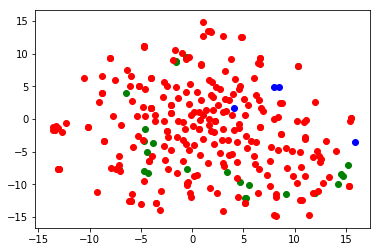

In [184]:
plt.scatter(X_embedded[0:len(a2Q),0], X_embedded[0:len(a2Q),1], color= 'blue')
plt.scatter(X_embedded[len(a2Q):len(a2Q)+len(a2P),0], X_embedded[len(a2Q):len(a2Q)+len(a2P),1], color = 'green')
plt.scatter(X_embedded[len(a2Q)+len(a2P):,0], X_embedded[len(a2Q)+len(a2P):,1], color = 'red')

In [102]:
[word for word in candidateTerms(test['QID'][99], test['Question'][99], 350).keys()]

['god',
 'religious',
 'human',
 'language',
 'beliefs',
 'religion',
 'sense',
 'humans',
 'spiritual',
 'knowledge',
 'buddhism',
 'fundamental',
 'beings',
 'understanding',
 'theory',
 'ancient',
 'religions',
 'values',
 'people',
 'languages',
 'christianity',
 'important',
 'we',
 'nature',
 'respect',
 'moral',
 'origin',
 'belief',
 'common',
 'teachings',
 'meaning',
 'islam',
 'be',
 'of',
 'context',
 'expression',
 'cultural',
 'understand',
 'culture',
 'function',
 'traditions',
 'social',
 'specific',
 'are',
 'true',
 'word',
 'ethnic',
 'is',
 'no',
 'life',
 'muslims',
 'principles',
 'historical',
 'political',
 'it',
 'identity',
 'species',
 'faith',
 'population',
 'genetic',
 'do',
 'person',
 'means',
 'physical',
 'texts',
 'interpretation',
 'great',
 'influence',
 'cultures',
 'evidence',
 'or',
 'individuals',
 'buddhist',
 'terms',
 'defined',
 'countries',
 'principle',
 'if',
 'change',
 'characteristics',
 'biblical',
 'importance',
 'matter',
 'i',
 's

In [45]:
# np.asarray(wordList)[[1,4]]
print(filtered_text)

['relative', 'human', 'beings', 'word', 'jain', 'imply', 'terms', 'dsicpline', 'conquest']


In [145]:
def  popCan(docid, ct):
    example_doc = docs[str(docid)]

    doc = []
    for value in example_doc.values():
        doc.append(split_into_sentences(value))
    text = list(itertools.chain.from_iterable(doc))
    textLower = [t.lower() for t in text]
    tokens = [s.split() for s in textLower]
    table = str.maketrans('', '', string.punctuation)
    sentences = [[w.translate(table) for w in x if not w in stop] for x in tokens]
    flat_list = [item for sublist in sentences for item in sublist]
    c = Counter(flat_list)
    
    # The Popular Words
    popct = [word for word, count in c.most_common() if word in ct]
    
    #The non popular words
    nonpop = list(set(ct) - set(popct))
    
    #Stack popular and non popular words
    allw = popct + nonpop
    #Find Embedding
    popctE = vec(allw)
    return popctE

In [159]:
def exEM(row):
    question_text = prepare_question_text(test['QID'][row], test['Question'][row]) ##291
    docid = test['DocumentID'][row]
    ct = candidateTerms(test['QID'][row], test['Question'][row], 300).keys()
#     print((ct))
    a2Q= [word for word in [ w for w in question_text.split() if not w in stop] if word in wordList]
    ##Embedding of popular and non popular query
    popctE = popCan(docid, ct)
    #Embedding of Query terms minus stop words 
    a2QE = vec(a2Q)
    a2QE = np.mean(a2QE, axis =0 ) ##Taking the average of query terms
    X = np.vstack([a2QE, popctE])
    X_embedded = TSNE(n_components=2, verbose = 1, learning_rate=20, perplexity=50, n_iter=5000).fit_transform(X)
    return X_embedded

In [180]:
X_embedded = exEM(222)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 301 samples in 0.000s...
[t-SNE] Computed neighbors for 301 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 301 / 301
[t-SNE] Mean sigma: 1.744580
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.974018
[t-SNE] Error after 1600 iterations: 0.739944


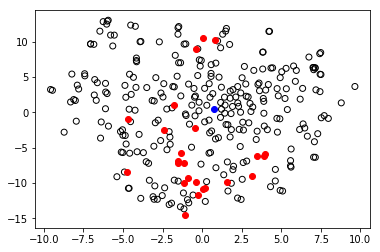

In [181]:

plt.scatter(X_embedded[0,0], X_embedded[0,1], color= 'blue')
# plt.scatter(np.mean(X_embedded[0:3], axis = 0)[0], np.mean(X_embedded[0:3], axis = 0)[1], color= 'blue')

plt.scatter(X_embedded[25:,0], X_embedded[25:,1],  facecolors='none', edgecolors='black')
plt.scatter(X_embedded[1:25,0], X_embedded[1:25,1], color = 'red')

## Experiments

In [68]:
row = test.loc[test['QID']==  969].index ##2871 good;3039, 3133 keyword missing4138



In [239]:
def check(q):
    doc = test.loc[test['QID']==  q]['DocumentID']
    print(doc)
    print(test.loc[test['QID']==  q]['RelevantPassages'])
    row = test.loc[test['QID']==  q].index
    question_text = prepare_question_text(test['QID'][row[0]], test['Question'][row[0]])
    print([word for word in [ w for w in question_text.split() if not w in stop] if word in wordList])
    print(question_text)
    arr = candidateTerms(test['QID'][row[0]], test['Question'][row[0]], 100)
#     arr = candidateTerms(test['QID'][row], test['DocumentID'][row], 'what was amazon diversifying to be', 50, 0.1)
    print(queryFormat(0.5, question_text, arr))

In [292]:
check(983)

131    305
Name: DocumentID, dtype: int64
131    2
Name: RelevantPassages, dtype: object
['international', 'olympic', 'committee', 'formed']
why was the international olympic committee formed
<text>#weight( 0.5 #combine ( international olympic committee formed ) 0.5 #weight( 0.0125 national 0.0124 international 0.0119 committee 0.0116 european 0.0114 world 0.0113 conference 0.0113 commission 0.0112 china 0.0111 association 0.0111 council 0.011 nations 0.011 cooperation 0.011 countries 0.0109 meeting 0.0109 union 0.0108 organization 0.0106 federation 0.0106 olympic 0.0105 team 0.0105 government 0.0104 championships 0.0103 officials 0.0103 united 0.0103 president 0.0103 group 0.0102 chinese 0.0102 member 0.0101 state 0.0101 talks 0.0101 members 0.0101 development 0.0101 competition 0.0101 university 0.0101 leaders 0.0101 states 0.0101 regional 0.01 organizations 0.01 delegation 0.01 joint 0.01 party 0.0099 economic 0.0099 official 0.0099 rights 0.0099 groups 0.0099 country 0.0099 eu 0.00

In [294]:
docs['305']['0']

'The International Olympic Committee is the supreme authority of the worldwide Olympic movement. It is an international, non-profit, non-governmental organization based in Lausanne, Switzerland. Its mission is enshrined in the Olympic Charter: to support the development of competitive sport by ethical and environmentally sustainable means. The IOC was created by Pierre de Coubertin, on 23 June 1894 with Demetrios Vikelas as its first president. Today its membership consists of 100 active members, 32 honorary members, and 1 honour member[who?]. The IOC is the supreme authority of the worldwide modern Olympic movement. The IOC organises the modern Olympic Games and Youth Olympic Games, held in summer and winter, every four years.'

In [273]:
docs['255']['97']

"Work and school holidays are determined by the Jewish holidays, and the official day of rest is Saturday, the Jewish Sabbath. Israel's substantial Arab minority has also left its imprint on Israeli culture in such spheres as architecture, music, and cuisine. Israeli literature is primarily poetry and prose written in Hebrew, as part of the renaissance of Hebrew as a spoken language since the mid-19th century, although a small body of literature is published in other languages, such as English. By law, two copies of all printed matter published in Israel must be deposited in the National Library of Israel at the Hebrew University of Jerusalem. In 2001, the law was amended to include audio and video recordings, and other non-print media. In 2013, 91 percent of the 7,863 books transferred to the library were in Hebrew."

## Effect of other Global Embedding Source

In [67]:
def GlobalNews(expansion_terms, lamda):
#     timeNow = datetime.now().strftime('%m%d%H%M')
    queryFile = 'C:/Users/nroy0/Downloads/Thesis/Lemur/dataset/input/globalNews/query_global_test'+str(lamda) + '_' + str(expansion_terms) +'.txt'
    ftrain = io.open(queryFile, 'w+', encoding="utf-8")
    ftrain.write('<parameters>\n')
    for i in range(len(test)):
#         print(i)
        if(test['QID'][i] != 4148 or test['QID'][i] != 1315):
            ftrain.write('<query>\n')
            ftrain.write('<number>'+ str(test['QID'][i]) +'</number>\n')
            question_text = prepare_question_text(test['QID'][i], test['Question'][i])
            arr = candidateTerms(test['QID'][i], test['Question'][i], expansion_terms)
            finalQueryText = queryFormat(lamda, question_text, arr)
            ftrain.write(finalQueryText + '\n')
            docid = test['DocumentID'][i]
            for item in docs[str(test['DocumentID'][i])].keys():
                ftrain.write('<workingSetDocno>'+str(docid)+'-'+str(item)+ '</workingSetDocno>\n')

            ftrain.write('</query>\n')
    ftrain.write('</parameters>')
    ftrain.close()
    return queryFile

In [68]:
# for expansion_terms in [5, 50, 100, 200, 300, 400, 500]:
for expansion_terms in [50]:
#     for lamda in [0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1]:
    for lamda in [ 0.45]: 
        startTime = time.time()
        queryFile = GlobalNews(expansion_terms, lamda)
        endTime = time.time()
        t_sec = round(endTime - startTime)
        (t_min, t_sec) = divmod(t_sec,60)
        print('Query File for Lamda {} and expansion terms {} created, time taken {} minutes and {} seconds'.format(lamda, expansion_terms, t_min, t_sec))
        for mu in [ 500]:
            startTime = time.time()
            outputFile = 'globalNews/QL_test_['+str(mu)+'_'+str(lamda)+'_'+str(expansion_terms)+'].indri'
            command_input= r'"C:\Users\nroy0\Downloads\Thesis\Lemur\bin\IndriRunQuery.exe" '+str(queryFile)+' -index=C:/Users/nroy0/Downloads/Thesis/Lemur/dataset/index/WPQA_mod -count=1000 -trecFormat=true -queryOffset=-1 -rule=method:dirichlet,mu:' +str(mu)+' -stemmer.name=krovetz > C:/Users/nroy0/Downloads/Thesis/trec_eval.9.0/baseline/'+str(outputFile) 
            args = shlex.split(command_input)
            p = subprocess.run(args, stderr=subprocess.STDOUT,shell=True)
            endTime = time.time()
            t_sec = round(endTime - startTime)
            (t_min, t_sec) = divmod(t_sec,60)
            print("Mu {} complete, time take {} min and {} sec".format(mu, t_min, t_sec ))

Query File for Lamda 0.45 and expansion terms 50 created, time taken 13 minutes and 41 seconds
Mu 500 complete, time take 0 min and 6 sec


In [59]:
path = r'C:\Users\nroy0\Downloads\Thesis\trec_eval.9.0\baseline\GlobalNews'
filenames = glob.glob(path + "/*.csv")
dfs = []
count = 0
for filename in filenames:
    match = re.search(r'\w\w\_\[\d\.?\d*\_\d\.?\d*\_\d+\]', filename)
    count = count + 1
#     print(count)
    colname = match.group()
    df = pd.read_table(filename,sep='\t', index_col=None, header=None, usecols=[2], skiprows =1, names =  [colname] , quoting=csv.QUOTE_NONE)
    dfs.append(df)
resultQLTest = pd.concat(dfs, axis=1, ignore_index = False)

resultQLTest['index']=[ 'num_q',
'num_ret',
'num_rel',
'num_rel_ret',
'map',
'gm_map',
'Rprec',
'bpref',
'recip_rank',
'iprec_at_recall_0.00',
'iprec_at_recall_0.10',
'iprec_at_recall_0.20',
'iprec_at_recall_0.30',
'iprec_at_recall_0.40',
'iprec_at_recall_0.50',
'iprec_at_recall_0.60',
'iprec_at_recall_0.70',
'iprec_at_recall_0.80',
'iprec_at_recall_0.90',
'iprec_at_recall_1.00',
'P_5',
'P_10',
'P_15',
'P_20',
'P_30',
'P_100',
'P_200',
'P_500',
'P_1000',
'recall_5',
'recall_10',
'recall_15',
'recall_20',
'recall_30',
'recall_100',
'recall_200',
'recall_500',
'recall_1000',
'infAP',
'gm_bpref',
'Rprec_mult_0.20',
'Rprec_mult_0.40',
'Rprec_mult_0.60',
'Rprec_mult_0.80',
'Rprec_mult_1.00',
'Rprec_mult_1.20',
'Rprec_mult_1.40',
'Rprec_mult_1.60',
'Rprec_mult_1.80',
'Rprec_mult_2.00',
'utility',
'11pt_avg',
'binG',
'G',
'ndcg',
'ndcg_rel',
'Rndcg',
'ndcg_cut_5',
'ndcg_cut_10',
'ndcg_cut_15',
'ndcg_cut_20',
'ndcg_cut_30',
'ndcg_cut_100',
'ndcg_cut_200',
'ndcg_cut_500',
'ndcg_cut_1000',
'map_cut_5',
'map_cut_10',
'map_cut_15',
'map_cut_20',
'map_cut_30',
'map_cut_100',
'map_cut_200',
'map_cut_500',
'map_cut_1000',
'relative_P_5',
'relative_P_10',
'relative_P_15',
'relative_P_20',
'relative_P_30',
'relative_P_100',
'relative_P_200',
'relative_P_500',
'relative_P_1000',
'success_1',
'success_5',
'success_10',
'set_P',
'set_relative_P',
'set_recall',
'set_map',
'set_F',
'num_nonrel_judged_ret']
resultQLTest = resultQLTest.set_index('index')
    resultQLTest.loc[['map', 'recip_rank','recall_10', 'P_10', 'ndcg', 'ndcg_cut_10']]

,QL_[1000_0.45_100],QL_[1000_0.45_200],QL_[1000_0.45_50],QL_[1000_0.6_100],QL_[1000_0.6_200],QL_[1000_0.6_50],QL_[1000_0.75_100],QL_[1000_0.75_200],QL_[1000_0.75_50],QL_[1250_0.45_100],...,QL_[500_0.75_50],QL_[750_0.45_100],QL_[750_0.45_200],QL_[750_0.45_50],QL_[750_0.6_100],QL_[750_0.6_200],QL_[750_0.6_50],QL_[750_0.75_100],QL_[750_0.75_200],QL_[750_0.75_50]
index,,,,,,,,,,,,,,,,,,,,,
map,0.5279,0.5265,0.5275,0.5249,0.5236,0.5262,0.5212,0.5201,0.5230,0.5251,...,0.5281,0.5303,0.5293,0.5298,0.5282,0.5266,0.5295,0.5240,0.5228,0.5262
recip_rank,0.6161,0.6145,0.6152,0.6132,0.6123,0.6147,0.6105,0.6096,0.6125,0.6126,...,0.6185,0.6191,0.6180,0.6191,0.6177,0.6159,0.6187,0.6140,0.6129,0.6163
recall_10,0.7369,0.7326,0.7395,0.7299,0.7244,0.7335,0.7231,0.7174,0.7264,0.7365,...,0.7283,0.7381,0.7341,0.7401,0.7290,0.7266,0.7329,0.7248,0.7205,0.7290
P_10,0.1154,0.1147,0.1157,0.1141,0.1134,0.1148,0.1130,0.1123,0.1136,0.1153,...,0.1139,0.1155,0.1148,0.1159,0.1140,0.1137,0.1146,0.1133,0.1128,0.1140
ndcg,0.6601,0.6587,0.6599,0.6574,0.6562,0.6586,0.6544,0.6534,0.6560,0.6578,...,0.6601,0.6620,0.6609,0.6620,0.6601,0.6587,0.6614,0.6567,0.6556,0.6586
ndcg_cut_10,0.5923,0.5900,0.5927,0.5880,0.5855,0.5902,0.5834,0.5810,0.5858,0.5899,...,0.5905,0.5945,0.5926,0.5950,0.5904,0.5886,0.5926,0.5861,0.5841,0.5891


In [62]:
resultQLTest.loc['ndcg_cut_10'].idxmax(axis=1)

'QL_[500_0.45_50]'

In [64]:
resultQLTest['QL_[500_0.45_50]'].loc[ 'ndcg_cut_10']

0.5978